# Applying your own post processing
This demo shows you how to use the ``post`` formatoption to apply your own post processing scripts.

It requires the ``'demo.nc'`` netCDF file, ``netCDF4`` and the 
[psy-maps](http://psyplot.readthedocs.io/projects/psy-maps/en/latest/) plugin.

In [1]:
import psyplot.project as psy
%matplotlib inline
%config InlineBackend.close_figures = False

## Usage
The ``post`` formatoption let's you apply your own script to modify your data. 
Let's start with a simple plot of the wind speed:

psyplot.project.Project([    arr0: 3-dim DataArray of u, v, with (variable, lat, lon)=(2, 96, 192), lev=1e+05, time=1979-01-31T18:00:00])


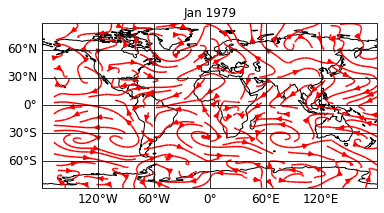

In [2]:
sp = psy.plot.mapvector('demo.nc', name=[['u', 'v']], plot='stream', 
                        color='red', title='%b %Y')
print(sp)

It is hard to see the continents below this amount of arrows. So we might
want to enhance our plot with cartopy's [stock_img](http://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html?highlight=stock_img#cartopy.mpl.geoaxes.GeoAxes.stock_img).

But since there is now formatoption for it, we can now either define a
new plotter and add the formatoption, or we use the ``post`` formatoption.

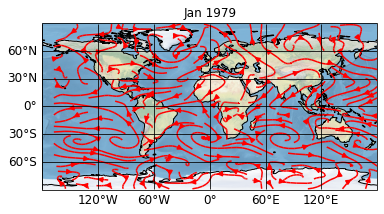

In [3]:
sp.update(enable_post=True,
          post='self.stock_img = self.ax.stock_img()')
sp.show()

The first parameter ``enable_post=True`` sets the ``enable_post`` 
attribute of the plotter to ``True``. This attribute is by default set to 
``False`` because it is always a security vulnerability to use the built-in 
``exec`` function which is used by the ``post`` formatoption. We could, however, 
already have included this in our first definition of the project via

```python
    sp = psy.plot.mapvector('demo.nc', name=[['u', 'v']], plot='stream', color='red',
                            enable_post=True)
```

The second parameter ``post='self.ax.stock_img()'`` updates the 
``post`` formatoption. It accepts an executable python script as a string. Note that 
we make use of the ``self`` variable, the only variable that is given to the script.
It is the [Formatoption](http://psyplot.readthedocs.io/en/latest/api/psyplot.plotter.html#psyplot.plotter.Formatoption) instance that performs the
update. Hence you can access all the necessary attributes and informations:

* the axes through ``self.ax``
* the figure through ``self.ax.figure``
* the data that is plotted through ``self.data``
* the raw data from the dataset through ``self.raw_data``
* the plotter through ``self.plotter``
* any other formatoption in the plotter, e.g. the ``title`` through ``self.plotter.title``

For example, let's add another feature that adds the mean of the plotted
variables to the plot. For this, let's first have a look into the ``plot_data``
attribute of the plotter which includes the data that is visualized and
that is accessible through the ``data`` attribute of the ``post`` formatoption:

In [4]:
sp.plotters[0].plot_data

<xarray.DataArray (variable: 2, lat: 96, lon: 192)>
array([[[-5.548854  , -5.470729  , -5.3847914 , ..., -5.7344007 ,
         -5.6802015 , -5.618678  ],
        [-4.1748304 , -4.246608  , -4.30276   , ..., -3.8872328 ,
         -3.9927015 , -4.0898695 ],
        [-2.2866468 , -2.6035414 , -2.8896742 , ..., -1.2148695 ,
         -1.585475  , -1.94485   ],
        ...,
        [-1.9463148 , -1.8501234 , -1.7676039 , ..., -2.3105726 ,
         -2.1772718 , -2.0556898 ],
        [-2.6640882 , -2.547389  , -2.434596  , ..., -3.0415297 ,
         -2.9111586 , -2.785182  ],
        [-3.4873304 , -3.3711195 , -3.2514906 , ..., -3.8120375 ,
         -3.7080336 , -3.5996351 ]],

       [[ 2.3220043 ,  2.5290356 ,  2.7336254 , ...,  1.6891918 ,
          1.9015942 ,  2.1125317 ],
        [ 1.3434887 ,  1.6203442 ,  1.906477  , ...,  0.57639885,
          0.8200512 ,  1.0759106 ],
        [ 0.1662426 ,  0.6325512 ,  1.1335278 , ..., -0.97780037,
         -0.64235115, -0.26002693],
        ...,
        [-2.2136402 , -2.2927418 , -2.3772144 , ..., -1.996355  ,
         -2.0661793 , -2.138445  ],
        [-2.2043629 , -2.2819996 , -2.3586597 , ..., -1.9577808 ,
         -2.04323   , -2.1252613 ],
        [-1.8645191 , -1.9768238 , -2.0837574 , ..., -1.4978199 ,
         -1.624773  , -1.7468433 ]]], dtype=float32)
Coordinates:
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
    lev       float64 1e+05
    time      datetime64[ns] 1979-01-31T18:00:00
  * variable  (variable) <U1 'u' 'v'
Attributes:
    CDI:          Climate Data Interface version 1.6.8 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Mon Aug 17 22:51:40 2015: cdo -r copy test-t2m-u-v.nc test-...
    title:        Test file
    CDO:          Climate Data Operators version 1.6.8rc2 (http://mpimet.mpg....
    long_name:    zonal wind-velocity
    units:        m/s
    code:         131
    table:        128
    grid_type:    gaussian

It is a 3-dimensional array, where the first dimension consists of
the zonal wind speed ``'u'`` and the meridional wind speed ``'v'``. So
let's add their means as a text to the plot:

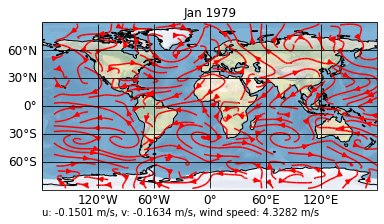

In [5]:
sp.update(post="""
self.stock_img = self.ax.stock_img()
umean = self.data[0].mean().values
vmean = self.data[1].mean().values
abs_mean = ((self.data[0]**2 + self.data[1]**2)**0.5).mean().values
self.text = self.ax.text(
    0., -0.15, 
    'u: %1.4f m/s, v: %1.4f m/s, wind speed: %1.4f m/s' % (
        umean, vmean, abs_mean), 
    transform=self.ax.transAxes)""")
sp.show()

## Timing
psyplot is intended to work interactively. By default, the ``post`` formatoption
is only updated when you personally update it. However, you can modify this
timing using the ``post_timing`` formatoption. It can be either

* ``'never'``: The default which requires a manual update
* ``'replot'``: To update it when the data changes
* ``'always'``: To always update it.

For example, in the current setting, when we change the data to the second
time step via

psyplot.project.Project([    arr0: 3-dim DataArray of u, v, with (variable, lat, lon)=(2, 96, 192), lev=1e+05, time=1979-02-28T18:00:00])


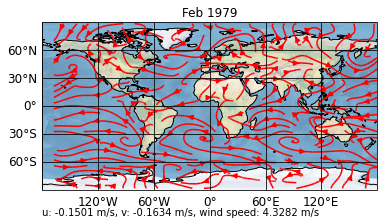

In [6]:
sp.update(time=1)
print(sp)
sp.show()

Our means are not updated, for this, we have to

1. set the ``post_timing`` to ``'replot'``
2. slightly modify our ``post`` script to not plot two texts
   above each other

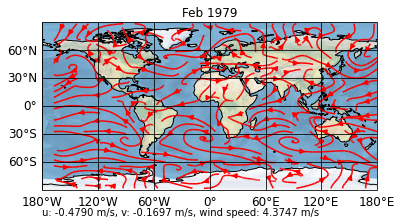

In [7]:
sp.update(post_timing='replot', post="""
self.stock_img = self.ax.stock_img()
umean = self.data[0].mean().values
vmean = self.data[1].mean().values
abs_mean = ((self.data[0]**2 + self.data[1]**2)**0.5).mean().values
if hasattr(self, 'text'):
    text = self.text
else:
    text = self.ax.text(0., -0.15, '', 
                        transform=self.ax.transAxes)
text.set_text( 
    'u: %1.4f m/s, v: %1.4f m/s, wind speed: %1.4f m/s' % (
        umean, vmean, abs_mean))""")
sp.show()

Now, if we update to the third timestep, our means are also
calculated

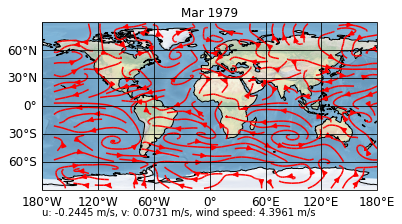

In [8]:
sp.update(time=2)
sp.show()

# Saving and loading
Saving a project is straight forward via the ``save_project`` method

In [9]:
d = sp.save_project()

However, when loading the project, the ``enable_post`` attribute is
(for security reasons) again set to ``False``. So if you are sure you
can trust the post processing scripts in the ``post`` formatoption,
load your project with ``enable_post=True``

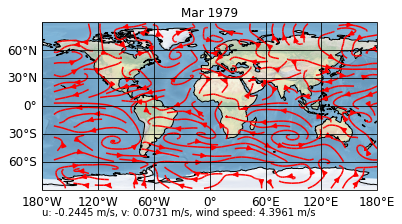

In [10]:
psy.close('all')
sp = psy.Project.load_project(d, enable_post=True)

In [11]:
psy.close('all')